In [23]:
# 단계 1: 데이터 로드 및 준비
import pandas as pd
data = pd.read_csv('./final_data/preprocessed_targetV2.csv')

## 1. 자양2동

In [24]:
# 컬럼 삭제 및 '자양2동'만 필터링
data = data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore')
data = data[data['행정동'] == '자양2동']

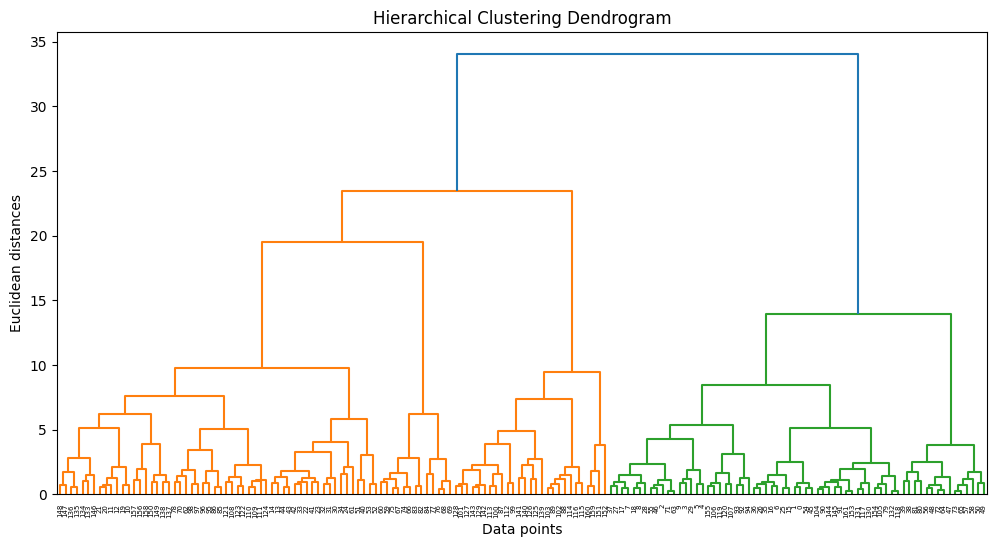

                 경도         위도  subway_최소거리(m)  500m지하철역개수  bus_최소거리(m)  \
cluster                                                                   
1        127.081808  37.526212      911.054379    0.000000   404.316885   
2        127.087281  37.534876      264.811886    1.037037    97.088356   
3        127.082729  37.528898      663.866394    0.000000   210.198056   
4        127.082934  37.530435      693.076573    0.000000   168.037008   

         500m버스정류장개수  badplace_최소거리(m)   500m술집개수  parking_최소거리(m)  500내주차장개수  \
cluster                                                                         
1           0.303030        357.012110   2.590909       223.787688   6.681818   
2          11.111111        149.865805  38.777778       127.985696   8.481481   
3           2.307692        107.360123  20.153846       104.367346  26.000000   
4           4.553571        172.272717  19.107143       140.593597   8.196429   

         300m보호구역여부  200m위험구역여부  
cluster                     

In [25]:
# 숫자형으로 변환 (추가된 부분)
data['300m보호구역여부'] = data['300m보호구역여부'].astype(int)
data['200m위험구역여부'] = data['200m위험구역여부'].astype(int)

# 단계 2: 분석에 필요한 특징(feature) 선택
features = data[['subway_최소거리(m)', 'bus_최소거리(m)', '500m버스정류장개수',
                 'badplace_최소거리(m)', '500m술집개수', '300m보호구역여부',
                 '200m위험구역여부', 'parking_최소거리(m)', '500내주차장개수', '500m지하철역개수']]

# 단계 3: 데이터 표준화 (정규화)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 단계 4: 계층적 군집화 수행 (Ward linkage 사용)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
linked = linkage(features_scaled, method='ward')

# 단계 5: 덴드로그램 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

# 단계 6: 클러스터 수 결정 및 데이터에 적용
num_clusters = 4
data['cluster'] = fcluster(linked, num_clusters, criterion='maxclust').astype(int)

# 단계 7: 클러스터 결과 분석 및 요약
cluster_summary = data.groupby('cluster').mean(numeric_only=True)  # numeric_only 추가
print(cluster_summary)

# 단계 8: 클러스터 결과 지도 시각화
import folium

map_center = [data['위도'].mean(), data['경도'].mean()]
m = folium.Map(location=map_center, zoom_start=14)

colors = ['red', 'blue', 'green', 'purple']

for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color=colors[row['cluster']-1],
        fill=True,
        fill_opacity=0.7,
        popup=f"Cluster {row['cluster']}"
    ).add_to(m)

In [26]:
m

In [ ]:
# CSV로 저장
output_path = './final/clustered_coordinates(Jayang2_dong).csv'
data.to_csv(output_path, index=False)

## 1. 사용한 알고리즘
- 계층적 군집화(Hierarchical Clustering)
    - 데이터 간 유클리디안 거리를 기준으로 가장 유사한 데이터끼리 묶어 점점 큰 군집으로 합쳐가는 알고리즘

## 2. 사용된 특성 및 선택 이유
- 총 10개의 특성을 사용하여 입지 분석을 수행함.
    - subway_최소거리(m):	지하철역 접근성이 높을수록 고객 접근성이 증가함
    - 500m지하철역개수:	주변 지하철역이 많을수록 교통 편의성이 좋음
    - bus_최소거리(m):	버스정류장이 가까울수록 고객 접근성 향상
    - 500m버스정류장개수:	주변 버스정류장이 많을수록 교통 접근성이 좋아짐
    - badplace_최소거리(m):	술집 등 유해 시설로부터 멀수록 어린이 및 가족 고객에게 적합
    - 500m술집개수:	술집과 같은 상업 시설이 적을 적을수록 어린이 및 가족 고객에게 적합
    - 300m보호구역여부:	어린이 보호구역이 있으면 안전성 및 가족 단위 고객 유입에 좋음
    - 200m위험구역여부:	위험 구역은 없을수록 어린이 안전성에 좋음
    - parking_최소거리(m):	주차장과의 거리가 가까우면 가족 단위 고객이 방문하기 편리
    - 500내주차장개수:	주차장 개수가 많을수록 접근성 및 편의성이 향상


## 3. 알고리즘에 대한 설명
- 선택한 특성들로 데이터를 표준화하여 각 특성의 영향력을 동일하게 맞춤
- 표준화된 데이터로 유클리디안 거리를 계산하여, 계층적 군집화를 수행함
- 덴드로그램을 통해 군집 간의 거리를 시각화하여 최적의 군집 수를 4개로 결정함
- 최종 군집 결과를 데이터에 적용해 클러스터를 할당하고, 이를 지도로 시각화함

## 4. 군집화 결과
- 클러스터 2 (최적 입지, 파란색)
    - 지하철 접근성: 매우 우수 (거리 264m, 지하철역 개수 많음)
    - 버스 접근성: 최고 수준 (정류장 거리 97m, 정류장 수 매우 많음)
    - 유해시설 거리: 다소 가까움 (약 150m)
    - 술집 수: 가장 많음 (39개), 안전성 측면에서 다소 불리
    - 어린이 보호구역: 높은 비율
    - 위험구역 여부: 전혀 없음 (안전성 우수)
    - 주차장 접근성: 매우 좋음 (128m), 주차장 수 많음 (8.5개)

👉 종합 평가: 접근성과 편의성에서 최고의 조건. 다만, 술집이 많은 점만 주의하면 최적의 입지임.

- 클러스터 4 (좋은 입지, 보라색)
    - 지하철 접근성: 보통 수준 (거리 693m, 지하철역 없음)
    - 버스 접근성: 우수 (정류장 거리 168m, 정류장 수 적절함)
    - 유해시설 거리: 적당히 멀어 안전성 양호 (172m)
    - 술집 수: 많음 (약 19개), 다소 안전성 우려
    - 어린이 보호구역: 매우 높음
    - 위험구역 여부: 없음 (안전)
    - 주차장 접근성: 우수 (140m), 주차장 수 적당히 많음 (8개)

👉 종합 평가: 전반적인 안전성과 접근성이 좋아 차선책으로 추천할 만한 입지임.

- 클러스터 3 (부적합한 입지, 초록색)
    - 지하철 접근성: 보통 (663m, 지하철역 없음)
    - 버스 접근성: 중간 수준 (정류장 거리 210m, 정류장 수 적음)
    - 유해시설 거리: 매우 가까워 위험 (107m)
    - 술집 수: 많음 (약 20개), 안전성 취약
    - 어린이 보호구역: 중간 정도
    - 위험구역 여부: 존재함 (가장 큰 문제)
    - 주차장 접근성: 최상 (104m), 주차장 수 많음 (26개)

👉 종합 평가: 주차시설만 뛰어나며, 유해시설과 위험지역이 가까워서 안전성 문제가 심각함. 키즈카페 입지로는 부적합.


## 2. 광장동

In [28]:
# 단계 1: 데이터 로드 및 준비
import pandas as pd
data = pd.read_csv('./final_data/preprocessed_targetV2.csv')

In [29]:
# 컬럼 삭제 및 '광장동'만 필터링
data = data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore')
data = data[data['행정동'] == '광장동']

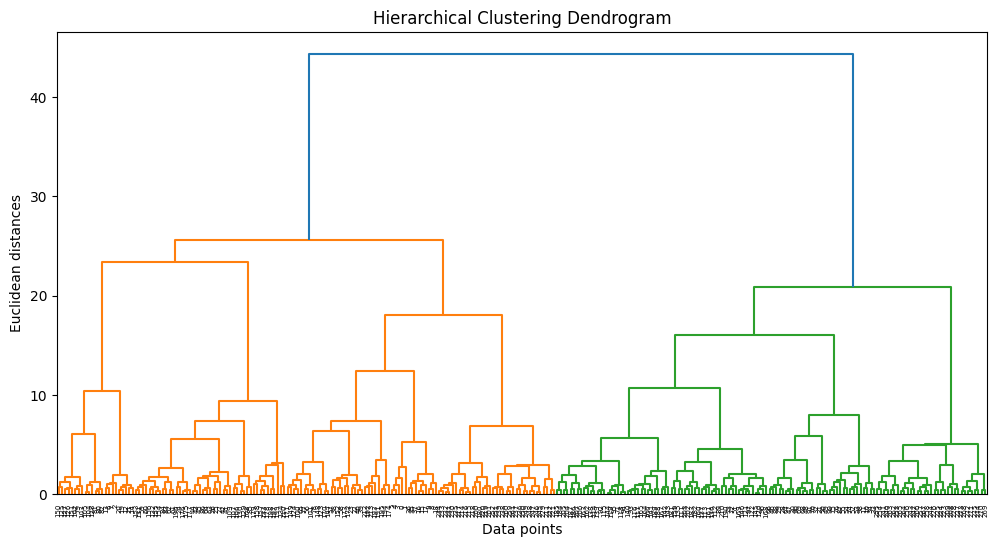

                 경도         위도  subway_최소거리(m)  500m지하철역개수  bus_최소거리(m)  \
cluster                                                                   
1        127.105605  37.550804      752.118165    0.000000   400.503226   
2        127.105681  37.546161      609.127318    0.387500   148.151331   
3        127.103486  37.547871      353.947488    0.777778   136.191204   
4        127.101394  37.543233      298.005045    0.608696   125.825693   

         500m버스정류장개수  badplace_최소거리(m)   500m술집개수  parking_최소거리(m)  500내주차장개수  \
cluster                                                                         
1           1.054688        381.435750   1.437500       578.739982   0.031250   
2           5.462500        187.952128   7.200000       470.650289   0.000000   
3           6.777778        155.697303   8.000000       177.669416   1.133333   
4           7.000000         92.616661  10.913043       355.722741   0.260870   

         300m보호구역여부  200m위험구역여부  
cluster                     

In [30]:
# 숫자형으로 변환 (추가된 부분)
data['300m보호구역여부'] = data['300m보호구역여부'].astype(int)
data['200m위험구역여부'] = data['200m위험구역여부'].astype(int)

# 단계 2: 분석에 필요한 특징(feature) 선택
features = data[['subway_최소거리(m)', 'bus_최소거리(m)', '500m버스정류장개수',
                 'badplace_최소거리(m)', '500m술집개수', '300m보호구역여부',
                 '200m위험구역여부', 'parking_최소거리(m)', '500내주차장개수', '500m지하철역개수']]

# 단계 3: 데이터 표준화 (정규화)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 단계 4: 계층적 군집화 수행 (Ward linkage 사용)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
linked = linkage(features_scaled, method='ward')

# 단계 5: 덴드로그램 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

# 단계 6: 클러스터 수 결정 및 데이터에 적용
num_clusters = 4
data['cluster'] = fcluster(linked, num_clusters, criterion='maxclust').astype(int)

# 단계 7: 클러스터 결과 분석 및 요약
cluster_summary = data.groupby('cluster').mean(numeric_only=True)  # numeric_only 추가
print(cluster_summary)

# 단계 8: 클러스터 결과 지도 시각화
import folium

map_center = [data['위도'].mean(), data['경도'].mean()]
m = folium.Map(location=map_center, zoom_start=14)

colors = ['red', 'blue', 'green', 'purple']

for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color=colors[row['cluster']-1],
        fill=True,
        fill_opacity=0.7,
        popup=f"Cluster {row['cluster']}"
    ).add_to(m)

In [31]:
m

## 1. 사용한 알고리즘
- 계층적 군집화(Hierarchical Clustering)
    - 데이터 간 유클리디안 거리를 기준으로 가장 유사한 데이터끼리 묶어 점점 큰 군집으로 합쳐가는 알고리즘

## 2. 사용된 특성 및 선택 이유
- 총 10개의 특성을 사용하여 입지 분석을 수행함.
    - subway_최소거리(m):	지하철역 접근성이 높을수록 고객 접근성이 증가함
    - 500m지하철역개수:	주변 지하철역이 많을수록 교통 편의성이 좋음
    - bus_최소거리(m):	버스정류장이 가까울수록 고객 접근성 향상
    - 500m버스정류장개수:	주변 버스정류장이 많을수록 교통 접근성이 좋아짐
    - badplace_최소거리(m):	술집 등 유해 시설로부터 멀수록 어린이 및 가족 고객에게 적합
    - 500m술집개수:	술집과 같은 상업 시설이 적을 적을수록 어린이 및 가족 고객에게 적합
    - 300m보호구역여부:	어린이 보호구역이 있으면 안전성 및 가족 단위 고객 유입에 좋음
    - 200m위험구역여부:	위험 구역은 없을수록 어린이 안전성에 좋음
    - parking_최소거리(m):	주차장과의 거리가 가까우면 가족 단위 고객이 방문하기 편리
    - 500내주차장개수:	주차장 개수가 많을수록 접근성 및 편의성이 향상


## 3. 알고리즘에 대한 설명
- 선택한 특성들로 데이터를 표준화하여 각 특성의 영향력을 동일하게 맞춤
- 표준화된 데이터로 유클리디안 거리를 계산하여, 계층적 군집화를 수행함
- 덴드로그램을 통해 군집 간의 거리를 시각화하여 최적의 군집 수를 4개로 결정함
- 최종 군집 결과를 데이터에 적용해 클러스터를 할당하고, 이를 지도로 시각화함

## 4. 군집화 결과
- 클러스터 3 (가장 추천, 높은 접근성·안전성·균형잡힌 환경, 초록색)
    - 지하철 접근성: 우수 (지하철역 가까움, 역 개수 많음)
    - 버스 접근성: 우수 (버스정류장과 가까움, 정류장 개수 많음)
    - 유해시설 거리: 다소 가까움 (155m), 약간의 주의 필요
    - 술집 수: 적당히 적음 (8개)
    - 어린이 보호구역: 안전함
    - 위험지역 여부: 없음, 안전성 높음
    - 주차장 접근성: 우수 (177m), 주변 주차장 존재 양호

👉 최적 입지: 접근성, 안전성, 편의성 매우 우수하고 균형이 잘 잡힘. 추천도 높음

- 클러스터 2 (접근성 좋음, 일부 시설 아쉬움, 파란색)
    - 지하철 접근성: 보통 이상 (609m), 주변 지하철역 존재 양호
    - 버스 접근성: 좋음 (148m), 버스정류장 수 양호 (평균 5.5개)
    - 유해시설 거리: 적당한 거리 (약 188m)
    - 술집 수: 적당히 적음 (7개)
    - 어린이 보호구역: 안전성 중간
    - 위험지역 여부: 없음, 안전성 좋음
    - 주차장 접근성: 다소 떨어짐 (471m), 주변 주차시설 부족

👉 양호한 입지: 접근성은 좋으나 주차시설 부족과 중간 수준의 보호구역이 단점. 충분히 좋은 편이지만 차선책

- 클러스터 4 (부적합, 위험지역 및 유해시설 위험, 보라색)
    - 지하철 접근성: 매우 우수 (298m), 주변 역 존재
    - 버스 접근성: 매우 우수 (126m), 버스정류장 개수 많음 (7개)
    - 유해시설 거리: 매우 가까움 (92m), 안전성 문제 심각
    - 술집 수: 많음 (11개), 안전성 떨어짐
    - 어린이 보호구역: 존재율 100%, 매우 우수
    - 위험지역 여부: 있음 (위험 존재), 안전성 심각한 문제
    - 주차장 접근성: 보통 (355m), 주차장 매우 부족

👉 안전성 문제 심각: 교통 접근성 매우 우수하지만 안전성 문제가 커서 키즈카페로는 부적합한 지역

In [ ]:
# CSV로 저장
output_path = './final/clustered_coordinates(Gwangjang-dong).csv'
data.to_csv(output_path, index=False)